# ConvNets
***
Authors: Daniel Carneiro Freire - **2016074250**, 
         Felipe Bartelt de Assis Pessoa - **2016026841**

In order to perform a comparative study between object recognition techniques, we trained a convolutional network for the same dataset [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) used previously, for the Bag of Features (BoF) method.

For this, we used the libraries `tensorflow, sklearn` e `matplotlib`. The dataset was loaded directly from `tensorflow.keras.datasets.cifar10` 

In [48]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential, clone_model
from keras.layers import Dense, Dropout, Flatten
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

In [49]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()


Image dataset is normalized, such that values lie in the interval $[0,1]$, which facilitates the convergence of methods.

In [50]:
x_train, x_test = x_train / 255.0, x_test / 255.0


The created ConvNet was inspired by LeNet5, thus it uses 3 convolution layers and 2 NN layers, counting the output neuron. The net input is colored images with size $32\times 32$.

Convolution layers have $32,64\text{ e } 128$ filters, with activation functions `relu, swish, relu`, respectively. All convolutions use padding. The two first convolution layers use $5\times5$ kernel, while the third layer uses $3\times3$ kernel.

After each convolution layer a pooling is made, for the convolution layers that use `relu` activation, average pooling is used, while for the layer with `swish` max pooling is used. Every poolings has the same size and stride, both $2\times2$.

The first NN layer outputs a vector with length $84$ with `tanh` activation, just like the original LeNet5. The output with size $10$ is generated with `softmax` activation function.

Every layer and activation function was decided based on a lot of tests while aiming to create a ConvNet very similar to LeNet5.

In [51]:
model = Sequential()

model.add(Conv2D(32, kernel_size=5, activation='relu', padding='same', input_shape = (32, 32, 3)))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(64, kernel_size=5, activation='swish', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(84, activation='tanh'))
model.add(Dense(10, activation='softmax'))

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
average_pooling2d_2 (Average (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             


The model was trained using adam optimizer and accuracy metric in $25$ epochs, using test set as validation set.

In [53]:
model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=25, 
                    validation_data=(x_test, y_test))


Epoch 1/25
1563/1563 [==============================] - 9s 5ms/step - loss: 1.6849 - accuracy: 0.3842 - val_loss: 1.1539 - val_accuracy: 0.5941
Epoch 2/25
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0713 - accuracy: 0.6184 - val_loss: 0.9532 - val_accuracy: 0.6643
Epoch 3/25
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8644 - accuracy: 0.6956 - val_loss: 0.8572 - val_accuracy: 0.6992
Epoch 4/25
1563/1563 [==============================] - 7s 5ms/step - loss: 0.7255 - accuracy: 0.7471 - val_loss: 0.8365 - val_accuracy: 0.7129
Epoch 5/25
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6225 - accuracy: 0.7830 - val_loss: 0.8286 - val_accuracy: 0.7175
Epoch 6/25
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5334 - accuracy: 0.8136 - val_loss: 0.8489 - val_accuracy: 0.7225
Epoch 7/25
1563/1563 [==============================] - 7s 4ms/step - loss: 0.4460 - accuracy: 0.8462 - val_loss: 0.8638 - val_accuracy:


The mean accuracies obtained with the trained ConvNet, for training and test set, are presented:

In [54]:
out_fullconv_train = model.predict(x_train)
out_fullconv_test = model.predict(x_test)

m = tf.keras.metrics.Accuracy()
m.update_state(np.argmax(out_fullconv_train, axis=1), y_train.ravel())
r1 = m.result().numpy()

m2 = tf.keras.metrics.Accuracy()
m2.update_state(np.argmax(out_fullconv_test, axis=1), y_test.ravel())
r2 = m2.result().numpy()

print(f'Mean train accuracy: {r1}')
print(f'Mean test accuracy: {r2}')

Mean train accuracy: 0.9712600111961365
Mean test accuracy: 0.7203999757766724



Confusion matrices for the ConvNet are presented below

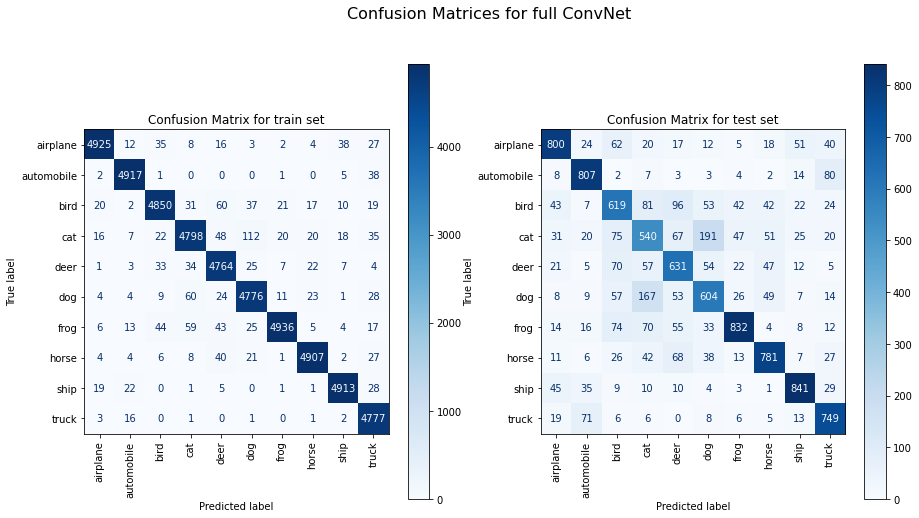

In [55]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

c1 = confusion_matrix(np.argmax(out_fullconv_train, axis=1), y_train.ravel())
c2 = confusion_matrix(np.argmax(out_fullconv_test, axis=1), y_test.ravel())

fig1, ax1 = plt.subplots(1,2)

disp = ConfusionMatrixDisplay(confusion_matrix=c1, display_labels=class_names)
disp2 = ConfusionMatrixDisplay(confusion_matrix=c2, display_labels=class_names)
disp.plot(include_values = True, cmap=plt.cm.Blues, ax = ax1[0], values_format = '.5g', xticks_rotation = 'vertical')
disp2.plot(include_values = True, cmap=plt.cm.Blues, ax = ax1[1], values_format = '.5g', xticks_rotation = 'vertical')

ax1[0].set_title('Confusion Matrix for train set')
ax1[1].set_title('Confusion Matrix for test set')
fig1.suptitle('Confusion Matrices for full ConvNet', fontsize=16)
fig1.set_size_inches(15, 8)
plt.show()


Next, we copy the trained ConvNet and remove the NN layers, the last two layers, including output one. Removing the top we end up with a network that only filters the input images and outputs $2048$ sized vectors.

Based on the output of this new network, for both training and test sets, we train a Random Forest with depth 20 in order to compare accuracies between the full ConvNet and RandomForest-based classification.

In [56]:
model_ = clone_model(model)

In [57]:
model_.pop()
model_.pop()
clf = RandomForestClassifier(max_depth=15, random_state=0)
out_conv_train = model_.predict(x_train)
out_conv_test = model_.predict(x_test)

clf.fit(out_conv_train, y_train.ravel())

out_forest_train = clf.predict(out_conv_train)
out_forest_test = clf.predict(out_conv_test)

Mean accuracies and confusion matrices, for training and test set, using the Random Forest classifier are shown below:

In [58]:
print('Mean train accuracy: {}'.format(clf.score(out_conv_train, y_train.ravel())))
print('Mean test accuracy: {}'.format(clf.score(out_conv_test, y_test.flatten())))

Mean train accuracy: 0.97574
Mean test accuracy: 0.4792


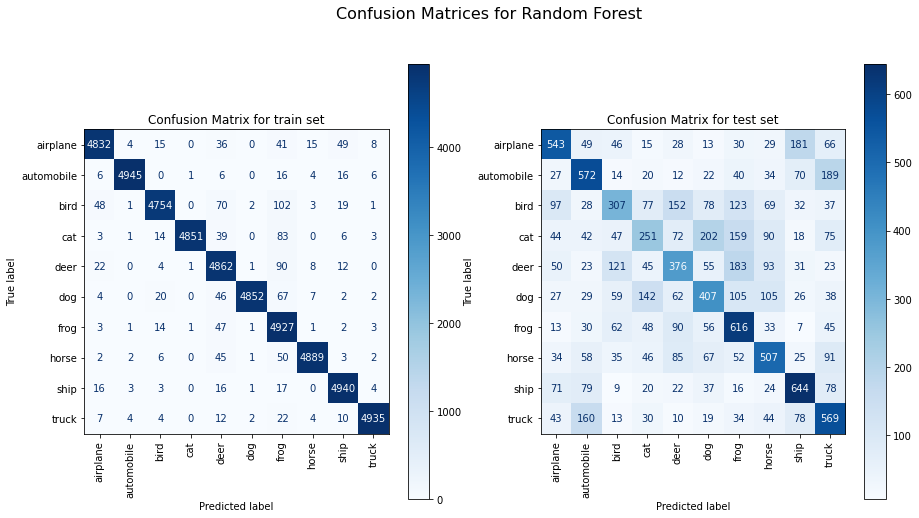

In [59]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
fig1, ax1 = plt.subplots(1,2)
plot_confusion_matrix(clf, out_conv_train, y_train.ravel(), ax=ax1[0], xticks_rotation = 'vertical', 
                      display_labels=class_names, values_format = '.5g', cmap=plt.cm.Blues)
plot_confusion_matrix(clf, out_conv_test, y_test.ravel(), ax=ax1[1], xticks_rotation = 'vertical',
                      display_labels=class_names, values_format = '.5g', cmap=plt.cm.Blues)
ax1[0].set_title('Confusion Matrix for train set')
ax1[1].set_title('Confusion Matrix for test set')
fig1.suptitle('Confusion Matrices for Random Forest', fontsize=16)
fig1.set_size_inches(15, 8)
plt.show()


Based on the results, its possible to say that the full ConvNet performs far better than the Random Forest approach. With the trained ConvNet we obtained $97\%$ accuracy on training set and $72\%$ accuracy on the test set, a satisfying result for such a shallow network. Its also possible to see that the network has difficulty differentiating cats from dogs.

Observing RandomForest-based classifier results we can see that it performed better on the training set than the full ConvNet, with $97.5\%$ accuracy. On the other hand, performance on the test set has dropped, obtaining $48\%$ accuracy.

In short, full ConvNet approach performed better than every other approach taken, reaching the highest accuracy on the test set. Next, the ConvNet+RandomForest performed slightly better than the trained NN with BoF, that obtained $43\%$ accuracy. Lastly, the worst performance was from Random Forest trained with BoF, reaching only $34\%$ accuracy.

The experiments suggest that convolutional networks are better to extract important image features and BoF approach should benefit from better image preprocessing. ConvNets were also faster to train than BoF generation. Although its possible that we have implemented a bad keypoint extractor and/or descriptor, it is conjectured that, in general, it is better to use convolutional networks than bag of features training.